# Introduction

This notebook is used to derive the accurcy assessment of the SVM model based on ground truth data. In this case, ground truth data for all landcover classes were collected using the Sentinel-2 image

In [1]:
from pathlib import Path
import itertools

import geopandas as gpd
import pandas as pd
import numpy as np
import scipy

from scipy import stats
import rasterio
from rasterio import plot
from sklearn.metrics import  confusion_matrix, accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

import matplotlib.pylab as plt

In [2]:
DATA_PATH = Path('/home/ioannisgkanatsios/Documents/SVM')

In [9]:
ground_truth = gpd.read_file(DATA_PATH.joinpath('stratified_sample','stratified_points','stratified_sample_2018.shp'))
ground_truth = ground_truth.rename(columns={'mosul_clas':'ground_truth'})

### Extract values from raster

In [11]:
# get lat and lon coordinates
lon = ground_truth['geometry'].apply(lambda p: p.x)
lat = ground_truth['geometry'].apply(lambda p: p.y)

pixel_val_extract = []
with rasterio.open(DATA_PATH.joinpath('outputs','mosul_clasified_2018.tif')) as src:
    built_up = src.read(1)
    transform = src.transform
    profile = src.profile
    # loop over coordinates and extract the pixel value at each lat and lon
    for x, y in zip(lon,lat):
        r,c = src.index(x, y)
        pixel_val = built_up[r,c]
        pixel_val_extract.append(pixel_val)
        
predicted = pd.DataFrame({'predicted':pixel_val_extract})
predicted['predicted'] = predicted['predicted'].astype(int)

## Plot ground truth data

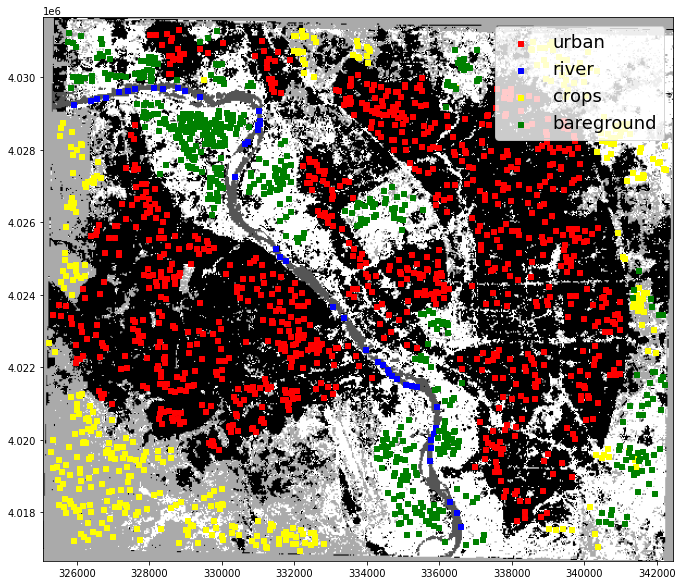

In [18]:
fig , ax = plt.subplots(ncols=1,figsize=(18, 10))

rasterio.plot.show(built_up,
                   ax=ax,
                   transform=transform,
                   cmap='gray')

# Plot reference points on the map
palette = {1: 'red',
           2: 'blue',
           3: 'yellow',
           4: 'green'}

labels = {1:'urban',
          2:'river',
          3: 'crops',
          4: 'bareground'}

for (ctype, data),label in zip(ground_truth.groupby('ground_truth'),labels):
    color = palette[ctype]
    label = labels[label]
    data.plot(color=color,
              ax=ax,
              marker='s',
              label=label,
              markersize=25)
                            
ax.legend(prop={'size': 18})
plt.show()

In [12]:
print ('accuracy:', accuracy_score(ground_truth['ground_truth'].values, predicted.values))

accuracy: 0.9100055897149245


## Classification Report

In [10]:
target_names = ['urban','river','bare','crops']
y_test = ground_truth['ground_truth'].values
y_pred = predicted['predicted'].values

In [11]:
print ('Classificaion report: \n %s' % 
       classification_report(y_test, y_pred, target_names=target_names))

Classificaion report: 
               precision    recall  f1-score   support

       urban       0.98      0.99      0.99       856
       river       0.96      1.00      0.98        44
        bare       0.91      0.70      0.79       366
       crops       0.82      0.94      0.88       523

    accuracy                           0.92      1789
   macro avg       0.92      0.91      0.91      1789
weighted avg       0.92      0.92      0.92      1789



In [12]:
print ('K-coefficient: \n %s' %
        cohen_kappa_score(y_test, y_pred))

K-coefficient: 
 0.8713586771490849


## Confusion Matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()



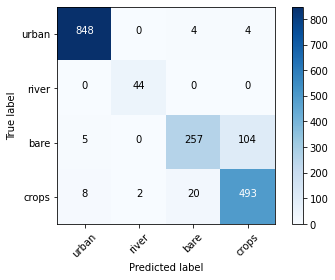

In [14]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,target_names)